In [1]:
import numpy as np
import matplotlib.pyplot as pl
import pandas as pd
import geopandas as gpd
import tensorflow as tf
from sklearn.utils import class_weight
from tensorflow import keras 
from tensorflow.keras import Sequential, activations, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    BatchNormalization, Activation, SpatialDropout2D, GlobalAveragePooling2D,
    Dense, Dropout, Flatten,
    Conv2D, MaxPooling2D, SeparableConv2D
)
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

# Import project utils scripts
import os
import sys

src_path = os.path.join('../src/')

if src_path not in sys.path:
    sys.path.append(src_path)

from statisticsUtils import recall_precision_fscore_from_confusion_matrix
from labelsUtils import Label
from regionUtils import vietnam_labels_coordinates
from rasterUtils import make_dataset_from_raster_files
from bandUtils import Band
from convNetUtils import (
    cross_validation,
    spatial_separation_dataset,
    cross_validation_from_csv_files,
)
from visualizationUtils import (
    display_cross_val_map_class,
    plot_confusion_matrix
)
from config import *

/home/simon/miniconda3/envs/tb/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
NB_PIXEL_AROUND=4
LABELS_COORDINATES = vietnam_labels_coordinates()

In [4]:
labels = [
    Label.COFFEE,
    Label.DENSE_FOREST,
    Label.URBAN,
    Label.WATER,
    Label.PEPPER,
    Label.TEA,
]

# Spatial validation

In [10]:
dataset_args = dict(
    labels = labels,
    raster_paths = [os.path.join(DATA_ROOT_PATH, 'Vietnam_2017_january_february/merged.tif')],
    labels_coordinates_list = [LABELS_COORDINATES],
    nb_pixel_around = NB_PIXEL_AROUND,
    save_on_disk=True,
    dataset_folder_name="Vietnam_2017_january_march"
)

dataset = make_dataset_from_raster_files(**dataset_args)

In [11]:
vietnam_shape = gpd.read_file(DISTRICTS_PATH)

In [12]:
df = pd.DataFrame(dataset, columns=['label', 'images', 'geometry'])
geo_df = gpd.GeoDataFrame(df, geometry='geometry')  # spacv requests a dataframe

In [13]:
geo_df

,label,images,geometry
0,COFFEE,../data/datasets/images/Vietnam_2017_january_m...,POINT (108.26488 14.02468)
1,COFFEE,../data/datasets/images/Vietnam_2017_january_m...,POINT (108.27041 14.02831)
2,COFFEE,../data/datasets/images/Vietnam_2017_january_m...,POINT (108.25905 14.03029)
3,COFFEE,../data/datasets/images/Vietnam_2017_january_m...,POINT (108.26109 14.03121)
4,COFFEE,../data/datasets/images/Vietnam_2017_january_m...,POINT (108.24059 14.02134)
...,...,...,...
9206,TEA,../data/datasets/images/Vietnam_2017_january_m...,POINT (107.76376 11.64308)
9207,TEA,../data/datasets/images/Vietnam_2017_january_m...,POINT (107.76379 11.64391)
9208,TEA,../data/datasets/images/Vietnam_2017_january_m...,POINT (107.76542 11.64458)
9209,TEA,../data/datasets/images/Vietnam_2017_january_m...,POINT (107.76581 11.64659)


In [14]:
geo_df['label']

0       COFFEE
1       COFFEE
2       COFFEE
3       COFFEE
4       COFFEE
         ...  
9206       TEA
9207       TEA
9208       TEA
9209       TEA
9210       TEA
Name: label, Length: 9211, dtype: object

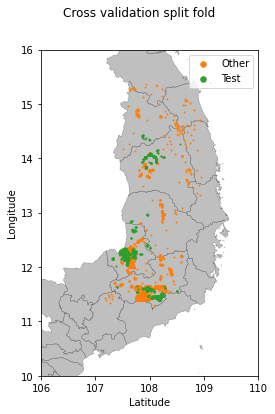

In [15]:
test, other = next(spatial_separation_dataset(geo_df, labels))
display_cross_val_map_class([other, test], vietnam_shape, f"Cross validation split fold")

In [7]:
test_csv_filename = 'Vietnam_2017_january_march_test.csv'
other_csv_filename = 'Vietnam_2017_january_march_other.csv'

In [17]:
# Save test set on the disk
test.to_csv(os.path.join(DATA_ROOT_PATH, 'datasets', test_csv_filename), index=False)

# Save other set on the disk
other.to_csv(os.path.join(DATA_ROOT_PATH, 'datasets', other_csv_filename), index=False)

In [8]:
NB_PIXEL_AROUND=4
NB_TESTS = 4
EPOCHS = 2000

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 9, 9, 7)           0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 9, 9, 7)           28        
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 9, 9, 32)          2048      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 9, 9, 32)          9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 3, 3, 64)          18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 3, 3, 64)         

/home/simon/miniconda3/envs/tb/lib/python3.9/site-packages/spacv/spacv.py:225: UserWarning: 1 folds contain less than three points and do not form polygons.
  warnings.warn(warn)



Validation 1, fold 1 :
---------------------------

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/2000
158/158 [==============================] - 1s 4ms/step - loss: 1.6650 - accuracy: 0.2355 - val_loss: 1.7453 - val_accuracy: 0.0599
Epoch 2/2000
158/158 [==============================] - 1s 4ms/step - loss: 1.4105 - accuracy: 0.3085 - val_loss: 1.6458 - val_accuracy: 0.1162
Epoch 3/2000
158/158 [==============================] - 1s 3ms/step - loss: 1.2522 - accuracy: 0.3534 - val_loss: 1.4495 - val_accuracy: 0.3841
Epoch 4/2000
158/158 [==============================] - 1s 4ms/step - loss: 1.2435 - accuracy: 0.3757 - val_loss: 1.3394 - val_accuracy: 0.3640
Epoch 5/2000
158/158 [==============================] - 1s 4ms/step - loss: 1.1733 - accuracy: 0.4129 - val_loss: 1.2639 - val_accuracy: 0.4351
Epoch 6/2000
158/158 [==============================] - 1s 3ms/step - loss: 1.1282 - accu

158/158 [==============================] - 1s 4ms/step - loss: 0.7763 - accuracy: 0.5663 - val_loss: 0.9600 - val_accuracy: 0.6200
Epoch 111/2000
158/158 [==============================] - 1s 4ms/step - loss: 0.7841 - accuracy: 0.5723 - val_loss: 0.9857 - val_accuracy: 0.5471
Epoch 112/2000
158/158 [==============================] - 1s 4ms/step - loss: 0.7677 - accuracy: 0.5711 - val_loss: 1.1500 - val_accuracy: 0.5205
Epoch 113/2000
158/158 [==============================] - 1s 4ms/step - loss: 0.7765 - accuracy: 0.5697 - val_loss: 0.9721 - val_accuracy: 0.5590
Epoch 114/2000
158/158 [==============================] - 1s 4ms/step - loss: 0.7810 - accuracy: 0.5626 - val_loss: 1.1276 - val_accuracy: 0.5068
Epoch 115/2000
158/158 [==============================] - 1s 4ms/step - loss: 0.7419 - accuracy: 0.5689 - val_loss: 1.1613 - val_accuracy: 0.5222
Epoch 116/2000
158/158 [==============================] - 1s 4ms/step - loss: 0.7796 - accuracy: 0.5663 - val_loss: 1.1004 - val_accuracy: 

158/158 [==============================] - 1s 5ms/step - loss: 0.6851 - accuracy: 0.6134 - val_loss: 1.0114 - val_accuracy: 0.5726
Epoch 223/2000
158/158 [==============================] - 1s 5ms/step - loss: 0.6695 - accuracy: 0.6227 - val_loss: 1.0121 - val_accuracy: 0.5365
Epoch 224/2000
158/158 [==============================] - 1s 4ms/step - loss: 0.6634 - accuracy: 0.6154 - val_loss: 1.1457 - val_accuracy: 0.4944
Epoch 225/2000
158/158 [==============================] - 1s 5ms/step - loss: 0.6697 - accuracy: 0.6112 - val_loss: 0.9291 - val_accuracy: 0.5957
Epoch 226/2000
158/158 [==============================] - 1s 5ms/step - loss: 0.6489 - accuracy: 0.6221 - val_loss: 1.0171 - val_accuracy: 0.5785
Epoch 227/2000
158/158 [==============================] - 1s 4ms/step - loss: 0.7022 - accuracy: 0.5774 - val_loss: 1.1669 - val_accuracy: 0.4861
Epoch 228/2000
158/158 [==============================] - 1s 4ms/step - loss: 0.7023 - accuracy: 0.5966 - val_loss: 1.0288 - val_accuracy: 

186/186 [==============================] - 1s 3ms/step - loss: 0.9434 - accuracy: 0.5155 - val_loss: 1.2325 - val_accuracy: 0.5265
Epoch 15/2000
186/186 [==============================] - 1s 4ms/step - loss: 0.9486 - accuracy: 0.5306 - val_loss: 1.5749 - val_accuracy: 0.4386
Epoch 16/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.9423 - accuracy: 0.5140 - val_loss: 1.3662 - val_accuracy: 0.5162
Epoch 17/2000
186/186 [==============================] - 1s 4ms/step - loss: 0.9376 - accuracy: 0.5235 - val_loss: 1.2928 - val_accuracy: 0.4864
Epoch 18/2000
186/186 [==============================] - 1s 4ms/step - loss: 0.9088 - accuracy: 0.5361 - val_loss: 1.4632 - val_accuracy: 0.5149
Epoch 19/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.9236 - accuracy: 0.5292 - val_loss: 1.4054 - val_accuracy: 0.5343
Epoch 20/2000
186/186 [==============================] - 1s 4ms/step - loss: 0.9022 - accuracy: 0.5346 - val_loss: 1.2949 - val_accuracy: 0.5369

186/186 [==============================] - 1s 4ms/step - loss: 0.6805 - accuracy: 0.6316 - val_loss: 1.4365 - val_accuracy: 0.5304
Epoch 127/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.6729 - accuracy: 0.6295 - val_loss: 1.4124 - val_accuracy: 0.5136
Epoch 128/2000
186/186 [==============================] - 1s 4ms/step - loss: 0.6846 - accuracy: 0.6203 - val_loss: 1.2260 - val_accuracy: 0.5420
Epoch 129/2000
186/186 [==============================] - 1s 4ms/step - loss: 0.6523 - accuracy: 0.6443 - val_loss: 1.1751 - val_accuracy: 0.5783
Epoch 130/2000
186/186 [==============================] - 1s 4ms/step - loss: 0.6812 - accuracy: 0.6359 - val_loss: 1.4356 - val_accuracy: 0.5123
Epoch 131/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.6546 - accuracy: 0.6436 - val_loss: 1.4594 - val_accuracy: 0.4942
Epoch 132/2000
186/186 [==============================] - 1s 4ms/step - loss: 0.6711 - accuracy: 0.6342 - val_loss: 1.2291 - val_accuracy: 

186/186 [==============================] - 1s 4ms/step - loss: 0.5831 - accuracy: 0.6789 - val_loss: 1.2565 - val_accuracy: 0.5938
Epoch 239/2000
186/186 [==============================] - 1s 4ms/step - loss: 0.5677 - accuracy: 0.6644 - val_loss: 1.2388 - val_accuracy: 0.5990
Epoch 240/2000
186/186 [==============================] - 1s 4ms/step - loss: 0.5633 - accuracy: 0.6850 - val_loss: 1.5523 - val_accuracy: 0.5550
Epoch 241/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5815 - accuracy: 0.6662 - val_loss: 1.3296 - val_accuracy: 0.5576
Epoch 242/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5761 - accuracy: 0.6707 - val_loss: 1.2052 - val_accuracy: 0.5834
Epoch 243/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5720 - accuracy: 0.6783 - val_loss: 1.3750 - val_accuracy: 0.5679
Epoch 244/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5735 - accuracy: 0.6704 - val_loss: 1.4688 - val_accuracy: 

186/186 [==============================] - 1s 3ms/step - loss: 0.5051 - accuracy: 0.7004 - val_loss: 1.3997 - val_accuracy: 0.5873
Epoch 351/2000
186/186 [==============================] - 1s 4ms/step - loss: 0.5458 - accuracy: 0.6882 - val_loss: 1.1721 - val_accuracy: 0.6145
Epoch 352/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5051 - accuracy: 0.7016 - val_loss: 1.3566 - val_accuracy: 0.6468
Epoch 353/2000
186/186 [==============================] - 1s 4ms/step - loss: 0.5136 - accuracy: 0.7001 - val_loss: 1.3881 - val_accuracy: 0.6054
Epoch 354/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5100 - accuracy: 0.7052 - val_loss: 1.3525 - val_accuracy: 0.6559
Epoch 355/2000
186/186 [==============================] - 1s 4ms/step - loss: 0.5251 - accuracy: 0.6997 - val_loss: 1.4823 - val_accuracy: 0.5757
Epoch 356/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5271 - accuracy: 0.6965 - val_loss: 1.2246 - val_accuracy: 

186/186 [==============================] - 1s 4ms/step - loss: 0.4773 - accuracy: 0.7141 - val_loss: 1.5137 - val_accuracy: 0.6378
Epoch 463/2000
186/186 [==============================] - 1s 4ms/step - loss: 0.4754 - accuracy: 0.7116 - val_loss: 1.3953 - val_accuracy: 0.6727
Epoch 464/2000
186/186 [==============================] - 1s 4ms/step - loss: 0.4699 - accuracy: 0.7201 - val_loss: 1.4764 - val_accuracy: 0.6326
Epoch 465/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4694 - accuracy: 0.7287 - val_loss: 1.3879 - val_accuracy: 0.6145
Epoch 466/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4668 - accuracy: 0.7240 - val_loss: 1.3840 - val_accuracy: 0.6197
Epoch 467/2000
186/186 [==============================] - 1s 4ms/step - loss: 0.4745 - accuracy: 0.7155 - val_loss: 1.3015 - val_accuracy: 0.6572
Epoch 468/2000
186/186 [==============================] - 1s 5ms/step - loss: 0.4823 - accuracy: 0.7240 - val_loss: 1.2767 - val_accuracy: 

186/186 [==============================] - 1s 4ms/step - loss: 0.4550 - accuracy: 0.7305 - val_loss: 1.5766 - val_accuracy: 0.6429
Epoch 575/2000
186/186 [==============================] - 1s 4ms/step - loss: 0.4578 - accuracy: 0.7329 - val_loss: 1.5166 - val_accuracy: 0.6378
Epoch 576/2000
186/186 [==============================] - 1s 4ms/step - loss: 0.4553 - accuracy: 0.7352 - val_loss: 1.4280 - val_accuracy: 0.6455
Epoch 577/2000
186/186 [==============================] - 1s 4ms/step - loss: 0.4186 - accuracy: 0.7396 - val_loss: 1.6435 - val_accuracy: 0.6481
Epoch 578/2000
186/186 [==============================] - 1s 4ms/step - loss: 0.4318 - accuracy: 0.7394 - val_loss: 1.4139 - val_accuracy: 0.6649
Epoch 579/2000
186/186 [==============================] - 1s 4ms/step - loss: 0.4331 - accuracy: 0.7459 - val_loss: 1.6257 - val_accuracy: 0.6507
Epoch 580/2000
186/186 [==============================] - 1s 4ms/step - loss: 0.4615 - accuracy: 0.7325 - val_loss: 1.4101 - val_accuracy: 

186/186 [==============================] - 1s 4ms/step - loss: 0.4061 - accuracy: 0.7486 - val_loss: 1.5828 - val_accuracy: 0.6572
Epoch 687/2000
186/186 [==============================] - 1s 4ms/step - loss: 0.4230 - accuracy: 0.7439 - val_loss: 1.4884 - val_accuracy: 0.6520
Epoch 688/2000
186/186 [==============================] - 1s 4ms/step - loss: 0.3944 - accuracy: 0.7672 - val_loss: 1.5510 - val_accuracy: 0.6533
Epoch 689/2000
186/186 [==============================] - 1s 4ms/step - loss: 0.4166 - accuracy: 0.7379 - val_loss: 1.2074 - val_accuracy: 0.6533
Epoch 690/2000
186/186 [==============================] - 1s 4ms/step - loss: 0.4117 - accuracy: 0.7521 - val_loss: 1.3612 - val_accuracy: 0.6300
Epoch 691/2000
186/186 [==============================] - 1s 4ms/step - loss: 0.4055 - accuracy: 0.7635 - val_loss: 1.4411 - val_accuracy: 0.6598
Epoch 692/2000
186/186 [==============================] - 1s 4ms/step - loss: 0.4196 - accuracy: 0.7523 - val_loss: 1.3968 - val_accuracy: 

186/186 [==============================] - 1s 4ms/step - loss: 0.4040 - accuracy: 0.7598 - val_loss: 1.4736 - val_accuracy: 0.6352
Epoch 799/2000
186/186 [==============================] - 1s 4ms/step - loss: 0.4056 - accuracy: 0.7592 - val_loss: 1.5160 - val_accuracy: 0.6261
Epoch 800/2000
186/186 [==============================] - 1s 4ms/step - loss: 0.4111 - accuracy: 0.7530 - val_loss: 1.3004 - val_accuracy: 0.6714
Epoch 801/2000
186/186 [==============================] - 1s 4ms/step - loss: 0.3787 - accuracy: 0.7692 - val_loss: 1.3856 - val_accuracy: 0.6598
Epoch 802/2000
186/186 [==============================] - 1s 4ms/step - loss: 0.4015 - accuracy: 0.7575 - val_loss: 1.4204 - val_accuracy: 0.6688
Epoch 803/2000
186/186 [==============================] - 1s 4ms/step - loss: 0.4067 - accuracy: 0.7647 - val_loss: 1.4294 - val_accuracy: 0.6572
Epoch 804/2000
186/186 [==============================] - 1s 4ms/step - loss: 0.4036 - accuracy: 0.7573 - val_loss: 1.3960 - val_accuracy: 

Epoch 2/2000
156/156 [==============================] - 1s 4ms/step - loss: 1.2404 - accuracy: 0.3438 - val_loss: 2.0021 - val_accuracy: 0.0771
Epoch 3/2000
156/156 [==============================] - 1s 3ms/step - loss: 1.1435 - accuracy: 0.3828 - val_loss: 1.5892 - val_accuracy: 0.2357
Epoch 4/2000
156/156 [==============================] - 1s 4ms/step - loss: 1.0664 - accuracy: 0.4123 - val_loss: 1.4601 - val_accuracy: 0.3522
Epoch 5/2000
156/156 [==============================] - 1s 4ms/step - loss: 1.0356 - accuracy: 0.4203 - val_loss: 1.3230 - val_accuracy: 0.3636
Epoch 6/2000
156/156 [==============================] - 1s 4ms/step - loss: 0.9877 - accuracy: 0.4513 - val_loss: 1.3415 - val_accuracy: 0.4572
Epoch 7/2000
156/156 [==============================] - 1s 4ms/step - loss: 0.9887 - accuracy: 0.4681 - val_loss: 1.2586 - val_accuracy: 0.4652
Epoch 8/2000
156/156 [==============================] - 1s 4ms/step - loss: 0.9727 - accuracy: 0.4696 - val_loss: 1.2484 - val_accuracy:

156/156 [==============================] - 1s 4ms/step - loss: 0.6220 - accuracy: 0.6484 - val_loss: 1.1879 - val_accuracy: 0.5805
Epoch 115/2000
156/156 [==============================] - 1s 4ms/step - loss: 0.6185 - accuracy: 0.6458 - val_loss: 1.1485 - val_accuracy: 0.5993
Epoch 116/2000
156/156 [==============================] - 1s 4ms/step - loss: 0.6285 - accuracy: 0.6408 - val_loss: 0.9813 - val_accuracy: 0.6347
Epoch 117/2000
156/156 [==============================] - 1s 4ms/step - loss: 0.6420 - accuracy: 0.6374 - val_loss: 1.0756 - val_accuracy: 0.5987
Epoch 118/2000
156/156 [==============================] - 1s 4ms/step - loss: 0.6377 - accuracy: 0.6444 - val_loss: 1.2880 - val_accuracy: 0.5268
Epoch 119/2000
156/156 [==============================] - 1s 4ms/step - loss: 0.6154 - accuracy: 0.6488 - val_loss: 1.0865 - val_accuracy: 0.6090
Epoch 120/2000
156/156 [==============================] - 1s 4ms/step - loss: 0.6205 - accuracy: 0.6506 - val_loss: 1.2374 - val_accuracy: 

Epoch 4/2000
168/168 [==============================] - 1s 4ms/step - loss: 1.1825 - accuracy: 0.3716 - val_loss: 1.2716 - val_accuracy: 0.3427
Epoch 5/2000
168/168 [==============================] - 1s 4ms/step - loss: 1.1529 - accuracy: 0.3836 - val_loss: 1.2491 - val_accuracy: 0.3301
Epoch 6/2000
168/168 [==============================] - 1s 4ms/step - loss: 1.0961 - accuracy: 0.4359 - val_loss: 1.2737 - val_accuracy: 0.3020
Epoch 7/2000
168/168 [==============================] - 1s 4ms/step - loss: 1.0653 - accuracy: 0.4445 - val_loss: 1.1796 - val_accuracy: 0.3901
Epoch 8/2000
168/168 [==============================] - 1s 4ms/step - loss: 1.0508 - accuracy: 0.4413 - val_loss: 1.1924 - val_accuracy: 0.4197
Epoch 9/2000
168/168 [==============================] - 1s 4ms/step - loss: 1.0485 - accuracy: 0.4625 - val_loss: 1.3741 - val_accuracy: 0.3627
Epoch 10/2000
168/168 [==============================] - 1s 4ms/step - loss: 1.0167 - accuracy: 0.4801 - val_loss: 1.2696 - val_accuracy

168/168 [==============================] - 1s 5ms/step - loss: 0.6577 - accuracy: 0.6905 - val_loss: 1.4273 - val_accuracy: 0.4611
Epoch 117/2000
168/168 [==============================] - 1s 5ms/step - loss: 0.6670 - accuracy: 0.6794 - val_loss: 1.2781 - val_accuracy: 0.5529
Epoch 118/2000
168/168 [==============================] - 1s 5ms/step - loss: 0.6585 - accuracy: 0.6842 - val_loss: 1.4384 - val_accuracy: 0.5107
Epoch 119/2000
168/168 [==============================] - 1s 4ms/step - loss: 0.6522 - accuracy: 0.6892 - val_loss: 1.6030 - val_accuracy: 0.4345
Epoch 120/2000
168/168 [==============================] - 1s 4ms/step - loss: 0.6639 - accuracy: 0.6829 - val_loss: 1.7317 - val_accuracy: 0.3731
Epoch 121/2000
168/168 [==============================] - 1s 4ms/step - loss: 0.6634 - accuracy: 0.6788 - val_loss: 1.5679 - val_accuracy: 0.4441
Epoch 122/2000
168/168 [==============================] - 1s 4ms/step - loss: 0.6661 - accuracy: 0.6787 - val_loss: 1.2855 - val_accuracy: 

173/173 [==============================] - 1s 5ms/step - loss: 0.9248 - accuracy: 0.5493 - val_loss: 1.1221 - val_accuracy: 0.6232
Epoch 18/2000
173/173 [==============================] - 1s 5ms/step - loss: 0.9363 - accuracy: 0.5217 - val_loss: 1.0447 - val_accuracy: 0.6071
Epoch 19/2000
173/173 [==============================] - 1s 5ms/step - loss: 0.8974 - accuracy: 0.5481 - val_loss: 1.4175 - val_accuracy: 0.4776
Epoch 20/2000
173/173 [==============================] - 1s 5ms/step - loss: 0.9021 - accuracy: 0.5350 - val_loss: 1.0038 - val_accuracy: 0.6173
Epoch 21/2000
173/173 [==============================] - 1s 5ms/step - loss: 0.9109 - accuracy: 0.5411 - val_loss: 0.9576 - val_accuracy: 0.6410
Epoch 22/2000
173/173 [==============================] - 1s 5ms/step - loss: 0.8978 - accuracy: 0.5418 - val_loss: 1.1382 - val_accuracy: 0.5868
Epoch 23/2000
173/173 [==============================] - 1s 5ms/step - loss: 0.8891 - accuracy: 0.5389 - val_loss: 0.8859 - val_accuracy: 0.6461

173/173 [==============================] - 1s 5ms/step - loss: 0.6443 - accuracy: 0.6392 - val_loss: 1.0395 - val_accuracy: 0.6071
Epoch 130/2000
173/173 [==============================] - 1s 5ms/step - loss: 0.6447 - accuracy: 0.6381 - val_loss: 0.9124 - val_accuracy: 0.6240
Epoch 131/2000
173/173 [==============================] - 1s 5ms/step - loss: 0.6595 - accuracy: 0.6363 - val_loss: 0.9829 - val_accuracy: 0.6469
Epoch 132/2000
173/173 [==============================] - 1s 5ms/step - loss: 0.6395 - accuracy: 0.6407 - val_loss: 0.8684 - val_accuracy: 0.6613
Epoch 133/2000
173/173 [==============================] - 1s 5ms/step - loss: 0.6603 - accuracy: 0.6308 - val_loss: 0.8923 - val_accuracy: 0.6588
Epoch 134/2000
173/173 [==============================] - 1s 5ms/step - loss: 0.6347 - accuracy: 0.6452 - val_loss: 0.9189 - val_accuracy: 0.6393
Epoch 135/2000
173/173 [==============================] - 1s 5ms/step - loss: 0.6274 - accuracy: 0.6417 - val_loss: 0.9855 - val_accuracy: 

173/173 [==============================] - 1s 4ms/step - loss: 0.5653 - accuracy: 0.6746 - val_loss: 0.9847 - val_accuracy: 0.6520
Epoch 242/2000
173/173 [==============================] - 1s 4ms/step - loss: 0.5462 - accuracy: 0.6750 - val_loss: 0.8687 - val_accuracy: 0.6825
Epoch 243/2000
173/173 [==============================] - 1s 4ms/step - loss: 0.5374 - accuracy: 0.6872 - val_loss: 0.9514 - val_accuracy: 0.6046
Epoch 244/2000
173/173 [==============================] - 1s 4ms/step - loss: 0.5521 - accuracy: 0.6883 - val_loss: 1.0565 - val_accuracy: 0.5783
Epoch 245/2000
173/173 [==============================] - 1s 4ms/step - loss: 0.5315 - accuracy: 0.6843 - val_loss: 1.2281 - val_accuracy: 0.5445
Epoch 246/2000
173/173 [==============================] - 1s 4ms/step - loss: 0.5423 - accuracy: 0.6885 - val_loss: 1.0793 - val_accuracy: 0.6105
Epoch 247/2000
173/173 [==============================] - 1s 4ms/step - loss: 0.5505 - accuracy: 0.6795 - val_loss: 1.0428 - val_accuracy: 

173/173 [==============================] - 1s 4ms/step - loss: 0.8736 - accuracy: 0.5579 - val_loss: 1.1560 - val_accuracy: 0.5262
Epoch 27/2000
173/173 [==============================] - 1s 4ms/step - loss: 0.8720 - accuracy: 0.5624 - val_loss: 1.0967 - val_accuracy: 0.4992
Epoch 28/2000
173/173 [==============================] - 1s 4ms/step - loss: 0.8564 - accuracy: 0.5638 - val_loss: 1.0380 - val_accuracy: 0.5854
Epoch 29/2000
173/173 [==============================] - 1s 4ms/step - loss: 0.8562 - accuracy: 0.5618 - val_loss: 1.1402 - val_accuracy: 0.5212
Epoch 30/2000
173/173 [==============================] - 1s 4ms/step - loss: 0.8534 - accuracy: 0.5548 - val_loss: 1.1080 - val_accuracy: 0.5034
Epoch 31/2000
173/173 [==============================] - 1s 4ms/step - loss: 0.8585 - accuracy: 0.5660 - val_loss: 1.0916 - val_accuracy: 0.5254
Epoch 32/2000
173/173 [==============================] - 1s 4ms/step - loss: 0.8366 - accuracy: 0.5667 - val_loss: 1.0163 - val_accuracy: 0.5964

173/173 [==============================] - 1s 4ms/step - loss: 0.6412 - accuracy: 0.6573 - val_loss: 1.3377 - val_accuracy: 0.4704
Epoch 139/2000
173/173 [==============================] - 1s 4ms/step - loss: 0.6294 - accuracy: 0.6659 - val_loss: 1.1727 - val_accuracy: 0.5195
Epoch 140/2000
173/173 [==============================] - 1s 4ms/step - loss: 0.6446 - accuracy: 0.6516 - val_loss: 1.1808 - val_accuracy: 0.4949
Epoch 141/2000
173/173 [==============================] - 1s 4ms/step - loss: 0.6237 - accuracy: 0.6586 - val_loss: 1.2791 - val_accuracy: 0.4924
Epoch 142/2000
173/173 [==============================] - 1s 4ms/step - loss: 0.6365 - accuracy: 0.6620 - val_loss: 1.1595 - val_accuracy: 0.5558
Epoch 143/2000
173/173 [==============================] - 1s 4ms/step - loss: 0.6129 - accuracy: 0.6722 - val_loss: 1.1826 - val_accuracy: 0.5245
Epoch 144/2000
173/173 [==============================] - 1s 4ms/step - loss: 0.6104 - accuracy: 0.6728 - val_loss: 1.2366 - val_accuracy: 

147/147 [==============================] - 1s 4ms/step - loss: 0.8958 - accuracy: 0.5534 - val_loss: 1.1400 - val_accuracy: 0.4811
Epoch 34/2000
147/147 [==============================] - 1s 4ms/step - loss: 0.8807 - accuracy: 0.5615 - val_loss: 1.2018 - val_accuracy: 0.4393
Epoch 35/2000
147/147 [==============================] - 1s 4ms/step - loss: 0.8684 - accuracy: 0.5668 - val_loss: 1.6932 - val_accuracy: 0.3418
Epoch 36/2000
147/147 [==============================] - 1s 4ms/step - loss: 0.8821 - accuracy: 0.5661 - val_loss: 1.3122 - val_accuracy: 0.4060
Epoch 37/2000
147/147 [==============================] - 1s 4ms/step - loss: 0.8752 - accuracy: 0.5522 - val_loss: 1.3452 - val_accuracy: 0.4005
Epoch 38/2000
147/147 [==============================] - 1s 4ms/step - loss: 0.8642 - accuracy: 0.5632 - val_loss: 1.4313 - val_accuracy: 0.3866
Epoch 39/2000
147/147 [==============================] - 1s 4ms/step - loss: 0.8645 - accuracy: 0.5727 - val_loss: 1.5164 - val_accuracy: 0.3284

147/147 [==============================] - 1s 4ms/step - loss: 0.6402 - accuracy: 0.6595 - val_loss: 1.2574 - val_accuracy: 0.4736
Epoch 146/2000
147/147 [==============================] - 1s 4ms/step - loss: 0.6678 - accuracy: 0.6531 - val_loss: 1.4076 - val_accuracy: 0.4398
Epoch 147/2000
147/147 [==============================] - 1s 4ms/step - loss: 0.6504 - accuracy: 0.6658 - val_loss: 1.1858 - val_accuracy: 0.5184
Epoch 148/2000
147/147 [==============================] - 1s 4ms/step - loss: 0.6398 - accuracy: 0.6603 - val_loss: 1.2055 - val_accuracy: 0.5209
Epoch 149/2000
147/147 [==============================] - 1s 4ms/step - loss: 0.6446 - accuracy: 0.6648 - val_loss: 0.9854 - val_accuracy: 0.6100
Epoch 150/2000
147/147 [==============================] - 1s 4ms/step - loss: 0.6546 - accuracy: 0.6529 - val_loss: 1.3908 - val_accuracy: 0.4498
Epoch 151/2000
147/147 [==============================] - 1s 4ms/step - loss: 0.6482 - accuracy: 0.6519 - val_loss: 1.4802 - val_accuracy: 

147/147 [==============================] - 1s 4ms/step - loss: 0.5576 - accuracy: 0.7017 - val_loss: 1.1889 - val_accuracy: 0.5622
Epoch 258/2000
147/147 [==============================] - 1s 4ms/step - loss: 0.5543 - accuracy: 0.7076 - val_loss: 1.3852 - val_accuracy: 0.4642
Epoch 259/2000
147/147 [==============================] - 1s 4ms/step - loss: 0.5599 - accuracy: 0.6962 - val_loss: 1.2065 - val_accuracy: 0.5398
Epoch 260/2000
147/147 [==============================] - 1s 4ms/step - loss: 0.5584 - accuracy: 0.6950 - val_loss: 1.3754 - val_accuracy: 0.4900
Epoch 261/2000
147/147 [==============================] - 1s 4ms/step - loss: 0.5521 - accuracy: 0.6994 - val_loss: 1.1559 - val_accuracy: 0.5592
Epoch 262/2000
147/147 [==============================] - 1s 4ms/step - loss: 0.5555 - accuracy: 0.6967 - val_loss: 0.9515 - val_accuracy: 0.6677
Epoch 263/2000
147/147 [==============================] - 1s 4ms/step - loss: 0.5756 - accuracy: 0.6884 - val_loss: 1.4245 - val_accuracy: 

Epoch 7/2000
160/160 [==============================] - 1s 4ms/step - loss: 1.0880 - accuracy: 0.3932 - val_loss: 0.9623 - val_accuracy: 0.6035
Epoch 8/2000
160/160 [==============================] - 1s 3ms/step - loss: 1.0655 - accuracy: 0.4074 - val_loss: 1.1167 - val_accuracy: 0.5686
Epoch 9/2000
160/160 [==============================] - 1s 4ms/step - loss: 1.0484 - accuracy: 0.3951 - val_loss: 0.9254 - val_accuracy: 0.6234
Epoch 10/2000
160/160 [==============================] - 1s 4ms/step - loss: 1.0190 - accuracy: 0.4109 - val_loss: 1.1545 - val_accuracy: 0.5524
Epoch 11/2000
160/160 [==============================] - 1s 4ms/step - loss: 1.0323 - accuracy: 0.4196 - val_loss: 1.1035 - val_accuracy: 0.5848
Epoch 12/2000
160/160 [==============================] - 1s 4ms/step - loss: 1.0140 - accuracy: 0.4294 - val_loss: 0.8511 - val_accuracy: 0.7170
Epoch 13/2000
160/160 [==============================] - 1s 4ms/step - loss: 1.0046 - accuracy: 0.4286 - val_loss: 1.0315 - val_accur

160/160 [==============================] - 1s 4ms/step - loss: 0.7241 - accuracy: 0.5685 - val_loss: 0.8982 - val_accuracy: 0.6577
Epoch 120/2000
160/160 [==============================] - 1s 4ms/step - loss: 0.7024 - accuracy: 0.5807 - val_loss: 0.9337 - val_accuracy: 0.6571
Epoch 121/2000
160/160 [==============================] - 1s 3ms/step - loss: 0.7104 - accuracy: 0.5669 - val_loss: 1.0299 - val_accuracy: 0.6372
Epoch 122/2000
160/160 [==============================] - 1s 4ms/step - loss: 0.7065 - accuracy: 0.5813 - val_loss: 0.8693 - val_accuracy: 0.6933
Epoch 123/2000
160/160 [==============================] - 1s 4ms/step - loss: 0.7007 - accuracy: 0.5881 - val_loss: 1.0083 - val_accuracy: 0.6696
Epoch 124/2000
160/160 [==============================] - 1s 4ms/step - loss: 0.6746 - accuracy: 0.5963 - val_loss: 0.9213 - val_accuracy: 0.6883
Epoch 125/2000
160/160 [==============================] - 1s 4ms/step - loss: 0.6827 - accuracy: 0.6018 - val_loss: 0.9744 - val_accuracy: 

176/176 [==============================] - 1s 4ms/step - loss: 0.7820 - accuracy: 0.5989 - val_loss: 1.1499 - val_accuracy: 0.5286
Epoch 52/2000
176/176 [==============================] - 1s 4ms/step - loss: 0.7605 - accuracy: 0.5956 - val_loss: 1.3975 - val_accuracy: 0.4732
Epoch 53/2000
176/176 [==============================] - 1s 4ms/step - loss: 0.7698 - accuracy: 0.5952 - val_loss: 1.0612 - val_accuracy: 0.5554
Epoch 54/2000
176/176 [==============================] - 1s 4ms/step - loss: 0.7717 - accuracy: 0.6018 - val_loss: 0.9994 - val_accuracy: 0.5793
Epoch 55/2000
176/176 [==============================] - 1s 4ms/step - loss: 0.7584 - accuracy: 0.6072 - val_loss: 1.1696 - val_accuracy: 0.5498
Epoch 56/2000
176/176 [==============================] - 1s 4ms/step - loss: 0.7532 - accuracy: 0.5961 - val_loss: 1.2859 - val_accuracy: 0.4779
Epoch 57/2000
176/176 [==============================] - 1s 3ms/step - loss: 0.7503 - accuracy: 0.6092 - val_loss: 1.0502 - val_accuracy: 0.5692

176/176 [==============================] - 1s 4ms/step - loss: 0.6038 - accuracy: 0.6687 - val_loss: 1.1957 - val_accuracy: 0.5443
Epoch 164/2000
176/176 [==============================] - 1s 4ms/step - loss: 0.6233 - accuracy: 0.6553 - val_loss: 1.0938 - val_accuracy: 0.5710
Epoch 165/2000
176/176 [==============================] - 1s 4ms/step - loss: 0.6086 - accuracy: 0.6641 - val_loss: 1.2423 - val_accuracy: 0.5535
Epoch 166/2000
176/176 [==============================] - 1s 4ms/step - loss: 0.6050 - accuracy: 0.6670 - val_loss: 1.0948 - val_accuracy: 0.5720
Epoch 167/2000
176/176 [==============================] - 1s 4ms/step - loss: 0.6013 - accuracy: 0.6753 - val_loss: 1.1834 - val_accuracy: 0.5544
Epoch 168/2000
176/176 [==============================] - 1s 4ms/step - loss: 0.6054 - accuracy: 0.6657 - val_loss: 1.1156 - val_accuracy: 0.5683
Epoch 169/2000
176/176 [==============================] - 1s 4ms/step - loss: 0.6088 - accuracy: 0.6643 - val_loss: 1.2127 - val_accuracy: 

183/183 [==============================] - 1s 4ms/step - loss: 0.7605 - accuracy: 0.6163 - val_loss: 1.4114 - val_accuracy: 0.4873
Epoch 50/2000
183/183 [==============================] - 1s 4ms/step - loss: 0.7373 - accuracy: 0.6199 - val_loss: 1.4369 - val_accuracy: 0.4572
Epoch 51/2000
183/183 [==============================] - 1s 4ms/step - loss: 0.7591 - accuracy: 0.6002 - val_loss: 1.6618 - val_accuracy: 0.3657
Epoch 52/2000
183/183 [==============================] - 1s 4ms/step - loss: 0.7471 - accuracy: 0.6184 - val_loss: 2.2883 - val_accuracy: 0.3218
Epoch 53/2000
183/183 [==============================] - 1s 4ms/step - loss: 0.7462 - accuracy: 0.6206 - val_loss: 1.4622 - val_accuracy: 0.4583
Epoch 54/2000
183/183 [==============================] - 1s 4ms/step - loss: 0.7289 - accuracy: 0.6347 - val_loss: 2.0105 - val_accuracy: 0.3530
Epoch 55/2000
183/183 [==============================] - 1s 4ms/step - loss: 0.7322 - accuracy: 0.6182 - val_loss: 1.9682 - val_accuracy: 0.3831

183/183 [==============================] - 1s 4ms/step - loss: 0.5958 - accuracy: 0.6896 - val_loss: 1.7006 - val_accuracy: 0.4907
Epoch 162/2000
183/183 [==============================] - 1s 4ms/step - loss: 0.6043 - accuracy: 0.6978 - val_loss: 1.8857 - val_accuracy: 0.4062
Epoch 163/2000
183/183 [==============================] - 1s 4ms/step - loss: 0.5942 - accuracy: 0.6939 - val_loss: 1.7351 - val_accuracy: 0.4433
Epoch 164/2000
183/183 [==============================] - 1s 4ms/step - loss: 0.5950 - accuracy: 0.6896 - val_loss: 1.5956 - val_accuracy: 0.4236
Epoch 165/2000
183/183 [==============================] - 1s 4ms/step - loss: 0.5839 - accuracy: 0.7043 - val_loss: 2.1300 - val_accuracy: 0.3056
Epoch 166/2000
183/183 [==============================] - 1s 4ms/step - loss: 0.6015 - accuracy: 0.6889 - val_loss: 1.6976 - val_accuracy: 0.4398
Epoch 167/2000
183/183 [==============================] - 1s 4ms/step - loss: 0.6033 - accuracy: 0.6845 - val_loss: 1.9047 - val_accuracy: 

Epoch 9/2000
163/163 [==============================] - 1s 4ms/step - loss: 1.0702 - accuracy: 0.4540 - val_loss: 1.0742 - val_accuracy: 0.4314
Epoch 10/2000
163/163 [==============================] - 1s 4ms/step - loss: 1.0490 - accuracy: 0.4695 - val_loss: 1.0201 - val_accuracy: 0.5306
Epoch 11/2000
163/163 [==============================] - 1s 4ms/step - loss: 1.0790 - accuracy: 0.4680 - val_loss: 1.1976 - val_accuracy: 0.4820
Epoch 12/2000
163/163 [==============================] - 1s 4ms/step - loss: 1.0329 - accuracy: 0.4716 - val_loss: 1.1226 - val_accuracy: 0.5200
Epoch 13/2000
163/163 [==============================] - 1s 4ms/step - loss: 1.0234 - accuracy: 0.4828 - val_loss: 1.0314 - val_accuracy: 0.5360
Epoch 14/2000
163/163 [==============================] - 1s 4ms/step - loss: 1.0114 - accuracy: 0.4973 - val_loss: 1.0233 - val_accuracy: 0.5712
Epoch 15/2000
163/163 [==============================] - 1s 4ms/step - loss: 1.0086 - accuracy: 0.4985 - val_loss: 1.1428 - val_acc

163/163 [==============================] - 1s 4ms/step - loss: 0.6973 - accuracy: 0.6599 - val_loss: 0.9047 - val_accuracy: 0.6165
Epoch 122/2000
163/163 [==============================] - 1s 4ms/step - loss: 0.6584 - accuracy: 0.6713 - val_loss: 1.2723 - val_accuracy: 0.5047
Epoch 123/2000
163/163 [==============================] - 1s 4ms/step - loss: 0.6754 - accuracy: 0.6648 - val_loss: 1.1553 - val_accuracy: 0.5240
Epoch 124/2000
163/163 [==============================] - 1s 4ms/step - loss: 0.6503 - accuracy: 0.6625 - val_loss: 1.1959 - val_accuracy: 0.5379
Epoch 125/2000
163/163 [==============================] - 1s 4ms/step - loss: 0.6797 - accuracy: 0.6622 - val_loss: 0.9472 - val_accuracy: 0.6352
Epoch 126/2000
163/163 [==============================] - 1s 4ms/step - loss: 0.6515 - accuracy: 0.6734 - val_loss: 1.0380 - val_accuracy: 0.5812
Epoch 127/2000
163/163 [==============================] - 1s 4ms/step - loss: 0.6707 - accuracy: 0.6545 - val_loss: 1.0905 - val_accuracy: 

170/170 [==============================] - 1s 4ms/step - loss: 0.8342 - accuracy: 0.5264 - val_loss: 0.9697 - val_accuracy: 0.6262
Epoch 40/2000
170/170 [==============================] - 1s 4ms/step - loss: 0.8429 - accuracy: 0.5363 - val_loss: 0.9031 - val_accuracy: 0.6662
Epoch 41/2000
170/170 [==============================] - 1s 4ms/step - loss: 0.8347 - accuracy: 0.5332 - val_loss: 0.9932 - val_accuracy: 0.6362
Epoch 42/2000
170/170 [==============================] - 1s 4ms/step - loss: 0.8434 - accuracy: 0.5288 - val_loss: 0.8941 - val_accuracy: 0.6823
Epoch 43/2000
170/170 [==============================] - 1s 4ms/step - loss: 0.8381 - accuracy: 0.5343 - val_loss: 0.9064 - val_accuracy: 0.6677
Epoch 44/2000
170/170 [==============================] - 1s 4ms/step - loss: 0.8197 - accuracy: 0.5422 - val_loss: 0.9565 - val_accuracy: 0.6309
Epoch 45/2000
170/170 [==============================] - 1s 4ms/step - loss: 0.8274 - accuracy: 0.5438 - val_loss: 0.9138 - val_accuracy: 0.6746

170/170 [==============================] - 1s 4ms/step - loss: 0.6556 - accuracy: 0.5850 - val_loss: 1.0414 - val_accuracy: 0.6685
Epoch 152/2000
170/170 [==============================] - 1s 4ms/step - loss: 0.6665 - accuracy: 0.5799 - val_loss: 1.0588 - val_accuracy: 0.6401
Epoch 153/2000
170/170 [==============================] - 1s 4ms/step - loss: 0.6434 - accuracy: 0.5936 - val_loss: 0.9758 - val_accuracy: 0.6946
Epoch 154/2000
170/170 [==============================] - 1s 4ms/step - loss: 0.6317 - accuracy: 0.6006 - val_loss: 1.1062 - val_accuracy: 0.6692
Epoch 155/2000
170/170 [==============================] - 1s 4ms/step - loss: 0.6476 - accuracy: 0.5995 - val_loss: 1.0521 - val_accuracy: 0.6746
Epoch 156/2000
170/170 [==============================] - 1s 4ms/step - loss: 0.6242 - accuracy: 0.6056 - val_loss: 0.9044 - val_accuracy: 0.7015
Epoch 157/2000
170/170 [==============================] - 1s 4ms/step - loss: 0.6538 - accuracy: 0.5907 - val_loss: 1.9179 - val_accuracy: 

170/170 [==============================] - 1s 4ms/step - loss: 0.6652 - accuracy: 0.5703 - val_loss: 0.9814 - val_accuracy: 0.6823
Epoch 264/2000
170/170 [==============================] - 1s 3ms/step - loss: 0.5829 - accuracy: 0.6271 - val_loss: 1.1222 - val_accuracy: 0.6823
Epoch 265/2000
170/170 [==============================] - 1s 4ms/step - loss: 0.5807 - accuracy: 0.6175 - val_loss: 1.0339 - val_accuracy: 0.6777
Epoch 266/2000
170/170 [==============================] - 1s 4ms/step - loss: 0.5689 - accuracy: 0.6357 - val_loss: 1.1740 - val_accuracy: 0.6853
Epoch 267/2000
170/170 [==============================] - 1s 4ms/step - loss: 0.5953 - accuracy: 0.6107 - val_loss: 1.1799 - val_accuracy: 0.6777
Epoch 268/2000
170/170 [==============================] - 1s 3ms/step - loss: 0.5643 - accuracy: 0.6322 - val_loss: 1.2239 - val_accuracy: 0.6654
Epoch 269/2000
170/170 [==============================] - 1s 4ms/step - loss: 0.5512 - accuracy: 0.6298 - val_loss: 1.1538 - val_accuracy: 

170/170 [==============================] - 1s 3ms/step - loss: 0.7052 - accuracy: 0.6414 - val_loss: 0.9903 - val_accuracy: 0.5708
Epoch 96/2000
170/170 [==============================] - 1s 4ms/step - loss: 0.6942 - accuracy: 0.6439 - val_loss: 1.0595 - val_accuracy: 0.5654
Epoch 97/2000
170/170 [==============================] - 1s 3ms/step - loss: 0.7041 - accuracy: 0.6456 - val_loss: 1.1887 - val_accuracy: 0.4300
Epoch 98/2000
170/170 [==============================] - 1s 4ms/step - loss: 0.7027 - accuracy: 0.6439 - val_loss: 0.9337 - val_accuracy: 0.6164
Epoch 99/2000
170/170 [==============================] - 1s 4ms/step - loss: 0.7047 - accuracy: 0.6476 - val_loss: 1.3276 - val_accuracy: 0.4207
Epoch 100/2000
170/170 [==============================] - 1s 4ms/step - loss: 0.7090 - accuracy: 0.6364 - val_loss: 0.9469 - val_accuracy: 0.6118
Epoch 101/2000
170/170 [==============================] - 1s 4ms/step - loss: 0.6973 - accuracy: 0.6377 - val_loss: 1.1328 - val_accuracy: 0.46

170/170 [==============================] - 1s 3ms/step - loss: 0.5796 - accuracy: 0.6973 - val_loss: 1.1065 - val_accuracy: 0.5576
Epoch 208/2000
170/170 [==============================] - 1s 4ms/step - loss: 0.5601 - accuracy: 0.7004 - val_loss: 1.2109 - val_accuracy: 0.5081
Epoch 209/2000
170/170 [==============================] - 1s 4ms/step - loss: 0.5869 - accuracy: 0.6977 - val_loss: 1.1897 - val_accuracy: 0.4795
Epoch 210/2000
170/170 [==============================] - 1s 4ms/step - loss: 0.5560 - accuracy: 0.7056 - val_loss: 0.9248 - val_accuracy: 0.6543
Epoch 211/2000
170/170 [==============================] - 1s 4ms/step - loss: 0.5729 - accuracy: 0.6993 - val_loss: 1.0340 - val_accuracy: 0.5978
Epoch 212/2000
170/170 [==============================] - 1s 4ms/step - loss: 0.5817 - accuracy: 0.6894 - val_loss: 0.9978 - val_accuracy: 0.6551
Epoch 213/2000
170/170 [==============================] - 1s 4ms/step - loss: 0.5606 - accuracy: 0.6990 - val_loss: 0.9383 - val_accuracy: 

170/170 [==============================] - 1s 4ms/step - loss: 0.4926 - accuracy: 0.7268 - val_loss: 0.9652 - val_accuracy: 0.6613
Epoch 320/2000
170/170 [==============================] - 1s 3ms/step - loss: 0.4956 - accuracy: 0.7307 - val_loss: 1.0513 - val_accuracy: 0.6504
Epoch 321/2000
170/170 [==============================] - 1s 4ms/step - loss: 0.5256 - accuracy: 0.7149 - val_loss: 0.9425 - val_accuracy: 0.6481
Epoch 322/2000
170/170 [==============================] - 1s 4ms/step - loss: 0.5202 - accuracy: 0.7197 - val_loss: 1.1345 - val_accuracy: 0.5166
Epoch 323/2000
170/170 [==============================] - 1s 4ms/step - loss: 0.4924 - accuracy: 0.7212 - val_loss: 1.1850 - val_accuracy: 0.5367
Epoch 324/2000
170/170 [==============================] - 1s 3ms/step - loss: 0.5089 - accuracy: 0.7279 - val_loss: 1.1275 - val_accuracy: 0.5522
Epoch 325/2000
170/170 [==============================] - 1s 4ms/step - loss: 0.5184 - accuracy: 0.7201 - val_loss: 1.1121 - val_accuracy: 

178/178 [==============================] - 1s 3ms/step - loss: 0.9052 - accuracy: 0.5758 - val_loss: 1.4297 - val_accuracy: 0.4428
Epoch 23/2000
178/178 [==============================] - 1s 3ms/step - loss: 0.8859 - accuracy: 0.5797 - val_loss: 1.3358 - val_accuracy: 0.4265
Epoch 24/2000
178/178 [==============================] - 1s 3ms/step - loss: 0.8942 - accuracy: 0.5637 - val_loss: 1.6465 - val_accuracy: 0.3881
Epoch 25/2000
178/178 [==============================] - 1s 3ms/step - loss: 0.8776 - accuracy: 0.5757 - val_loss: 1.4265 - val_accuracy: 0.4909
Epoch 26/2000
178/178 [==============================] - 1s 3ms/step - loss: 0.8678 - accuracy: 0.5813 - val_loss: 1.4901 - val_accuracy: 0.4342
Epoch 27/2000
178/178 [==============================] - 1s 3ms/step - loss: 0.8488 - accuracy: 0.5843 - val_loss: 1.3197 - val_accuracy: 0.4630
Epoch 28/2000
178/178 [==============================] - 1s 3ms/step - loss: 0.8719 - accuracy: 0.5862 - val_loss: 1.3698 - val_accuracy: 0.4678

178/178 [==============================] - 1s 3ms/step - loss: 0.6484 - accuracy: 0.6595 - val_loss: 1.4122 - val_accuracy: 0.4976
Epoch 135/2000
178/178 [==============================] - 1s 4ms/step - loss: 0.6534 - accuracy: 0.6733 - val_loss: 1.4162 - val_accuracy: 0.4880
Epoch 136/2000
178/178 [==============================] - 1s 3ms/step - loss: 0.6268 - accuracy: 0.6735 - val_loss: 1.2760 - val_accuracy: 0.5101
Epoch 137/2000
178/178 [==============================] - 1s 3ms/step - loss: 0.6555 - accuracy: 0.6505 - val_loss: 1.2601 - val_accuracy: 0.5207
Epoch 138/2000
178/178 [==============================] - 1s 4ms/step - loss: 0.6469 - accuracy: 0.6519 - val_loss: 1.2793 - val_accuracy: 0.5274
Epoch 139/2000
178/178 [==============================] - 1s 4ms/step - loss: 0.6505 - accuracy: 0.6691 - val_loss: 1.2730 - val_accuracy: 0.4745
Epoch 140/2000
178/178 [==============================] - 1s 3ms/step - loss: 0.6405 - accuracy: 0.6644 - val_loss: 1.3459 - val_accuracy: 

178/178 [==============================] - 1s 4ms/step - loss: 0.5692 - accuracy: 0.6886 - val_loss: 1.1299 - val_accuracy: 0.5917
Epoch 247/2000
178/178 [==============================] - 1s 4ms/step - loss: 0.5513 - accuracy: 0.7091 - val_loss: 1.0780 - val_accuracy: 0.6369
Epoch 248/2000
178/178 [==============================] - 1s 3ms/step - loss: 0.5336 - accuracy: 0.7054 - val_loss: 1.4388 - val_accuracy: 0.4928
Epoch 249/2000
178/178 [==============================] - 1s 4ms/step - loss: 0.5268 - accuracy: 0.7114 - val_loss: 1.3317 - val_accuracy: 0.5639
Epoch 250/2000
178/178 [==============================] - 1s 3ms/step - loss: 0.5387 - accuracy: 0.7035 - val_loss: 1.2130 - val_accuracy: 0.5831
Epoch 251/2000
178/178 [==============================] - 1s 3ms/step - loss: 0.5242 - accuracy: 0.7140 - val_loss: 1.1458 - val_accuracy: 0.5985
Epoch 252/2000
178/178 [==============================] - 1s 3ms/step - loss: 0.5521 - accuracy: 0.6982 - val_loss: 1.2309 - val_accuracy: 

178/178 [==============================] - 1s 4ms/step - loss: 0.4913 - accuracy: 0.7168 - val_loss: 1.0984 - val_accuracy: 0.6013
Epoch 359/2000
178/178 [==============================] - 1s 4ms/step - loss: 0.5179 - accuracy: 0.7196 - val_loss: 1.1295 - val_accuracy: 0.5975
Epoch 360/2000
178/178 [==============================] - 1s 3ms/step - loss: 0.5146 - accuracy: 0.7265 - val_loss: 1.3075 - val_accuracy: 0.5091
Epoch 361/2000
178/178 [==============================] - 1s 4ms/step - loss: 0.4893 - accuracy: 0.7237 - val_loss: 1.1806 - val_accuracy: 0.5850
Epoch 362/2000
178/178 [==============================] - 1s 3ms/step - loss: 0.5029 - accuracy: 0.7266 - val_loss: 1.4596 - val_accuracy: 0.5735
Epoch 363/2000
178/178 [==============================] - 1s 4ms/step - loss: 0.4955 - accuracy: 0.7291 - val_loss: 1.2852 - val_accuracy: 0.5716
Epoch 364/2000
178/178 [==============================] - 1s 3ms/step - loss: 0.5005 - accuracy: 0.7322 - val_loss: 1.2973 - val_accuracy: 

178/178 [==============================] - 1s 3ms/step - loss: 0.4461 - accuracy: 0.7472 - val_loss: 1.2141 - val_accuracy: 0.6254
Epoch 471/2000
178/178 [==============================] - 1s 3ms/step - loss: 0.4557 - accuracy: 0.7387 - val_loss: 1.5140 - val_accuracy: 0.5264
Epoch 472/2000
178/178 [==============================] - 1s 3ms/step - loss: 0.4674 - accuracy: 0.7382 - val_loss: 1.2625 - val_accuracy: 0.5783
Epoch 473/2000
178/178 [==============================] - 1s 3ms/step - loss: 0.4509 - accuracy: 0.7498 - val_loss: 1.3704 - val_accuracy: 0.5927
Epoch 474/2000
178/178 [==============================] - 1s 4ms/step - loss: 0.4366 - accuracy: 0.7561 - val_loss: 1.1935 - val_accuracy: 0.6340
Epoch 475/2000
178/178 [==============================] - 1s 3ms/step - loss: 0.4349 - accuracy: 0.7500 - val_loss: 1.4489 - val_accuracy: 0.5610
Epoch 476/2000
178/178 [==============================] - 1s 4ms/step - loss: 0.4456 - accuracy: 0.7435 - val_loss: 1.1810 - val_accuracy: 

178/178 [==============================] - 1s 4ms/step - loss: 0.4224 - accuracy: 0.7479 - val_loss: 1.2866 - val_accuracy: 0.6081
Epoch 583/2000
178/178 [==============================] - 1s 3ms/step - loss: 0.4252 - accuracy: 0.7585 - val_loss: 1.2845 - val_accuracy: 0.5639
Epoch 584/2000
178/178 [==============================] - 1s 4ms/step - loss: 0.4401 - accuracy: 0.7536 - val_loss: 1.3414 - val_accuracy: 0.6004
Epoch 585/2000
178/178 [==============================] - 1s 3ms/step - loss: 0.4221 - accuracy: 0.7584 - val_loss: 1.4995 - val_accuracy: 0.5591
Epoch 586/2000
178/178 [==============================] - 1s 4ms/step - loss: 0.4145 - accuracy: 0.7633 - val_loss: 1.2893 - val_accuracy: 0.5629
Epoch 587/2000
178/178 [==============================] - 1s 3ms/step - loss: 0.4274 - accuracy: 0.7566 - val_loss: 1.2571 - val_accuracy: 0.5975
Epoch 588/2000
178/178 [==============================] - 1s 3ms/step - loss: 0.3972 - accuracy: 0.7652 - val_loss: 1.4171 - val_accuracy: 

160/160 [==============================] - 1s 4ms/step - loss: 0.7451 - accuracy: 0.5530 - val_loss: 1.0383 - val_accuracy: 0.6012
Epoch 52/2000
160/160 [==============================] - 1s 4ms/step - loss: 0.7346 - accuracy: 0.5651 - val_loss: 1.0919 - val_accuracy: 0.6280
Epoch 53/2000
160/160 [==============================] - 1s 4ms/step - loss: 0.7481 - accuracy: 0.5614 - val_loss: 1.2054 - val_accuracy: 0.5558
Epoch 54/2000
160/160 [==============================] - 1s 4ms/step - loss: 0.7624 - accuracy: 0.5614 - val_loss: 1.2139 - val_accuracy: 0.5396
Epoch 55/2000
160/160 [==============================] - 1s 4ms/step - loss: 0.7444 - accuracy: 0.5528 - val_loss: 1.1370 - val_accuracy: 0.5944
Epoch 56/2000
160/160 [==============================] - 1s 4ms/step - loss: 0.7564 - accuracy: 0.5558 - val_loss: 1.1103 - val_accuracy: 0.5907
Epoch 57/2000
160/160 [==============================] - 1s 4ms/step - loss: 0.7518 - accuracy: 0.5682 - val_loss: 1.1332 - val_accuracy: 0.5925

160/160 [==============================] - 1s 4ms/step - loss: 0.5818 - accuracy: 0.6560 - val_loss: 0.9708 - val_accuracy: 0.6804
Epoch 164/2000
160/160 [==============================] - 1s 4ms/step - loss: 0.5687 - accuracy: 0.6499 - val_loss: 1.0272 - val_accuracy: 0.6642
Epoch 165/2000
160/160 [==============================] - 1s 4ms/step - loss: 0.6070 - accuracy: 0.6268 - val_loss: 0.9217 - val_accuracy: 0.6673
Epoch 166/2000
160/160 [==============================] - 1s 3ms/step - loss: 0.5872 - accuracy: 0.6373 - val_loss: 0.9889 - val_accuracy: 0.6629
Epoch 167/2000
160/160 [==============================] - 1s 4ms/step - loss: 0.5819 - accuracy: 0.6472 - val_loss: 1.1175 - val_accuracy: 0.5651
Epoch 168/2000
160/160 [==============================] - 1s 4ms/step - loss: 0.5842 - accuracy: 0.6484 - val_loss: 0.9515 - val_accuracy: 0.7059
Epoch 169/2000
160/160 [==============================] - 1s 4ms/step - loss: 0.5666 - accuracy: 0.6536 - val_loss: 1.0700 - val_accuracy: 

160/160 [==============================] - 1s 4ms/step - loss: 0.4975 - accuracy: 0.6890 - val_loss: 1.1380 - val_accuracy: 0.6604
Epoch 276/2000
160/160 [==============================] - 1s 3ms/step - loss: 0.5177 - accuracy: 0.6785 - val_loss: 1.0522 - val_accuracy: 0.7090
Epoch 277/2000
160/160 [==============================] - 1s 4ms/step - loss: 0.5012 - accuracy: 0.6859 - val_loss: 1.1678 - val_accuracy: 0.6854
Epoch 278/2000
160/160 [==============================] - 1s 3ms/step - loss: 0.4937 - accuracy: 0.6813 - val_loss: 1.0924 - val_accuracy: 0.6997
Epoch 279/2000
160/160 [==============================] - 1s 4ms/step - loss: 0.4936 - accuracy: 0.6817 - val_loss: 1.1266 - val_accuracy: 0.6910
Epoch 280/2000
160/160 [==============================] - 1s 3ms/step - loss: 0.4932 - accuracy: 0.6879 - val_loss: 1.0691 - val_accuracy: 0.7146
Epoch 281/2000
160/160 [==============================] - 1s 4ms/step - loss: 0.4894 - accuracy: 0.6904 - val_loss: 1.1334 - val_accuracy: 

171/171 [==============================] - 1s 3ms/step - loss: 0.6378 - accuracy: 0.6456 - val_loss: 1.2991 - val_accuracy: 0.4944
Epoch 95/2000
171/171 [==============================] - 1s 4ms/step - loss: 0.6422 - accuracy: 0.6441 - val_loss: 1.2070 - val_accuracy: 0.5369
Epoch 96/2000
171/171 [==============================] - 1s 3ms/step - loss: 0.6349 - accuracy: 0.6568 - val_loss: 1.0912 - val_accuracy: 0.5745
Epoch 97/2000
171/171 [==============================] - 1s 4ms/step - loss: 0.6330 - accuracy: 0.6477 - val_loss: 1.3954 - val_accuracy: 0.4808
Epoch 98/2000
171/171 [==============================] - 1s 3ms/step - loss: 0.6330 - accuracy: 0.6568 - val_loss: 1.1484 - val_accuracy: 0.5681
Epoch 99/2000
171/171 [==============================] - 1s 4ms/step - loss: 0.6351 - accuracy: 0.6514 - val_loss: 1.1735 - val_accuracy: 0.5513
Epoch 100/2000
171/171 [==============================] - 1s 3ms/step - loss: 0.6165 - accuracy: 0.6601 - val_loss: 1.1487 - val_accuracy: 0.520

180/180 [==============================] - 1s 4ms/step - loss: 0.8559 - accuracy: 0.5641 - val_loss: 1.5494 - val_accuracy: 0.4278
Epoch 31/2000
180/180 [==============================] - 1s 4ms/step - loss: 0.8441 - accuracy: 0.5726 - val_loss: 1.8058 - val_accuracy: 0.3692
Epoch 32/2000
180/180 [==============================] - 1s 4ms/step - loss: 0.8375 - accuracy: 0.5755 - val_loss: 1.2695 - val_accuracy: 0.5272
Epoch 33/2000
180/180 [==============================] - 1s 4ms/step - loss: 0.8358 - accuracy: 0.5912 - val_loss: 1.6371 - val_accuracy: 0.3891
Epoch 34/2000
180/180 [==============================] - 1s 4ms/step - loss: 0.8205 - accuracy: 0.5905 - val_loss: 1.2889 - val_accuracy: 0.4582
Epoch 35/2000
180/180 [==============================] - 1s 4ms/step - loss: 0.8439 - accuracy: 0.5758 - val_loss: 1.0991 - val_accuracy: 0.5680
Epoch 36/2000
180/180 [==============================] - 1s 5ms/step - loss: 0.8130 - accuracy: 0.5829 - val_loss: 1.5397 - val_accuracy: 0.3787

180/180 [==============================] - 1s 4ms/step - loss: 0.6485 - accuracy: 0.6666 - val_loss: 1.4709 - val_accuracy: 0.4644
Epoch 143/2000
180/180 [==============================] - 1s 4ms/step - loss: 0.6316 - accuracy: 0.6693 - val_loss: 1.4550 - val_accuracy: 0.4351
Epoch 144/2000
180/180 [==============================] - 1s 3ms/step - loss: 0.6386 - accuracy: 0.6569 - val_loss: 1.4238 - val_accuracy: 0.4655
Epoch 145/2000
180/180 [==============================] - 1s 4ms/step - loss: 0.6479 - accuracy: 0.6683 - val_loss: 1.2895 - val_accuracy: 0.4833
Epoch 146/2000
180/180 [==============================] - 1s 4ms/step - loss: 0.6435 - accuracy: 0.6653 - val_loss: 1.7215 - val_accuracy: 0.4038
Epoch 147/2000
180/180 [==============================] - 1s 4ms/step - loss: 0.6143 - accuracy: 0.6773 - val_loss: 1.6415 - val_accuracy: 0.4226
Epoch 148/2000
180/180 [==============================] - 1s 4ms/step - loss: 0.6271 - accuracy: 0.6605 - val_loss: 1.4781 - val_accuracy: 

150/150 [==============================] - 1s 5ms/step - loss: 0.8935 - accuracy: 0.5017 - val_loss: 1.1112 - val_accuracy: 0.4159
Epoch 55/2000
150/150 [==============================] - 1s 5ms/step - loss: 0.8865 - accuracy: 0.5127 - val_loss: 1.2687 - val_accuracy: 0.3736
Epoch 56/2000
150/150 [==============================] - 1s 5ms/step - loss: 0.8675 - accuracy: 0.5258 - val_loss: 1.2328 - val_accuracy: 0.5186
Epoch 57/2000
150/150 [==============================] - 1s 6ms/step - loss: 0.8718 - accuracy: 0.5275 - val_loss: 1.3306 - val_accuracy: 0.4634
Epoch 58/2000
150/150 [==============================] - 1s 5ms/step - loss: 0.8675 - accuracy: 0.5218 - val_loss: 1.3492 - val_accuracy: 0.4381
Epoch 59/2000
150/150 [==============================] - 1s 5ms/step - loss: 0.8614 - accuracy: 0.5298 - val_loss: 1.0752 - val_accuracy: 0.5041
Epoch 60/2000
150/150 [==============================] - 1s 5ms/step - loss: 0.8567 - accuracy: 0.5223 - val_loss: 1.0883 - val_accuracy: 0.5196

150/150 [==============================] - 1s 5ms/step - loss: 0.7000 - accuracy: 0.6115 - val_loss: 1.3307 - val_accuracy: 0.4231
Epoch 167/2000
150/150 [==============================] - 1s 5ms/step - loss: 0.7153 - accuracy: 0.5878 - val_loss: 1.1312 - val_accuracy: 0.4443
Epoch 168/2000
150/150 [==============================] - 1s 5ms/step - loss: 0.6894 - accuracy: 0.5965 - val_loss: 1.1277 - val_accuracy: 0.5165
Epoch 169/2000
150/150 [==============================] - 1s 5ms/step - loss: 0.6901 - accuracy: 0.6122 - val_loss: 0.9677 - val_accuracy: 0.6053
Epoch 170/2000
150/150 [==============================] - 1s 5ms/step - loss: 0.6884 - accuracy: 0.6134 - val_loss: 0.9651 - val_accuracy: 0.6465
Epoch 171/2000
150/150 [==============================] - 1s 5ms/step - loss: 0.7331 - accuracy: 0.5945 - val_loss: 1.2479 - val_accuracy: 0.4969
Epoch 172/2000
150/150 [==============================] - 1s 4ms/step - loss: 0.7189 - accuracy: 0.5930 - val_loss: 0.9668 - val_accuracy: 

150/150 [==============================] - 1s 4ms/step - loss: 0.6193 - accuracy: 0.6461 - val_loss: 1.4002 - val_accuracy: 0.3860
Epoch 279/2000
150/150 [==============================] - 1s 4ms/step - loss: 0.6217 - accuracy: 0.6459 - val_loss: 1.0944 - val_accuracy: 0.5495
Epoch 280/2000
150/150 [==============================] - 1s 4ms/step - loss: 0.5928 - accuracy: 0.6592 - val_loss: 1.3107 - val_accuracy: 0.4974
Epoch 281/2000
150/150 [==============================] - 1s 4ms/step - loss: 0.6183 - accuracy: 0.6565 - val_loss: 1.3281 - val_accuracy: 0.4964
Epoch 282/2000
150/150 [==============================] - 1s 4ms/step - loss: 0.6160 - accuracy: 0.6392 - val_loss: 1.1702 - val_accuracy: 0.5294
Epoch 283/2000
150/150 [==============================] - 1s 4ms/step - loss: 0.6024 - accuracy: 0.6490 - val_loss: 1.0848 - val_accuracy: 0.5810
Epoch 284/2000
150/150 [==============================] - 1s 4ms/step - loss: 0.6081 - accuracy: 0.6523 - val_loss: 1.1581 - val_accuracy: 

193/193 [==============================] - 1s 4ms/step - loss: 0.9910 - accuracy: 0.4977 - val_loss: 0.7879 - val_accuracy: 0.6965
Epoch 15/2000
193/193 [==============================] - 1s 4ms/step - loss: 0.9748 - accuracy: 0.5088 - val_loss: 1.0202 - val_accuracy: 0.5959
Epoch 16/2000
193/193 [==============================] - 1s 4ms/step - loss: 0.9597 - accuracy: 0.5081 - val_loss: 0.7626 - val_accuracy: 0.7002
Epoch 17/2000
193/193 [==============================] - 1s 4ms/step - loss: 0.9511 - accuracy: 0.5125 - val_loss: 1.1326 - val_accuracy: 0.5158
Epoch 18/2000
193/193 [==============================] - 1s 4ms/step - loss: 0.9580 - accuracy: 0.5089 - val_loss: 0.8152 - val_accuracy: 0.6629
Epoch 19/2000
193/193 [==============================] - 1s 4ms/step - loss: 0.9243 - accuracy: 0.5275 - val_loss: 0.9263 - val_accuracy: 0.5978
Epoch 20/2000
193/193 [==============================] - 1s 4ms/step - loss: 0.9358 - accuracy: 0.5165 - val_loss: 0.9970 - val_accuracy: 0.6276

193/193 [==============================] - 1s 4ms/step - loss: 0.6947 - accuracy: 0.6285 - val_loss: 0.8005 - val_accuracy: 0.6778
Epoch 127/2000
193/193 [==============================] - 1s 4ms/step - loss: 0.6902 - accuracy: 0.6282 - val_loss: 0.9625 - val_accuracy: 0.6164
Epoch 128/2000
193/193 [==============================] - 1s 4ms/step - loss: 0.6652 - accuracy: 0.6315 - val_loss: 1.1023 - val_accuracy: 0.6350
Epoch 129/2000
193/193 [==============================] - 1s 4ms/step - loss: 0.6646 - accuracy: 0.6330 - val_loss: 0.7616 - val_accuracy: 0.6946
Epoch 130/2000
193/193 [==============================] - 1s 4ms/step - loss: 0.7021 - accuracy: 0.6257 - val_loss: 0.9126 - val_accuracy: 0.6369
Epoch 131/2000
193/193 [==============================] - 1s 4ms/step - loss: 0.6850 - accuracy: 0.6299 - val_loss: 0.8289 - val_accuracy: 0.6797
Epoch 132/2000
193/193 [==============================] - 1s 4ms/step - loss: 0.6840 - accuracy: 0.6246 - val_loss: 1.0133 - val_accuracy: 

146/146 [==============================] - 1s 4ms/step - loss: 1.6459 - accuracy: 0.2321 - val_loss: 1.7813 - val_accuracy: 0.0814
Epoch 2/2000
146/146 [==============================] - 1s 4ms/step - loss: 1.3539 - accuracy: 0.3161 - val_loss: 1.7128 - val_accuracy: 0.2571
Epoch 3/2000
146/146 [==============================] - 1s 4ms/step - loss: 1.2227 - accuracy: 0.3672 - val_loss: 1.6617 - val_accuracy: 0.2097
Epoch 4/2000
146/146 [==============================] - 1s 4ms/step - loss: 1.1554 - accuracy: 0.3883 - val_loss: 1.3462 - val_accuracy: 0.4000
Epoch 5/2000
146/146 [==============================] - 1s 4ms/step - loss: 1.1378 - accuracy: 0.4170 - val_loss: 1.2078 - val_accuracy: 0.5119
Epoch 6/2000
146/146 [==============================] - 1s 4ms/step - loss: 1.0899 - accuracy: 0.4309 - val_loss: 1.4977 - val_accuracy: 0.3738
Epoch 7/2000
146/146 [==============================] - 1s 4ms/step - loss: 1.0628 - accuracy: 0.4535 - val_loss: 1.2739 - val_accuracy: 0.4877
Epoch

146/146 [==============================] - 1s 5ms/step - loss: 0.6854 - accuracy: 0.6204 - val_loss: 1.0549 - val_accuracy: 0.5816
Epoch 114/2000
146/146 [==============================] - 1s 5ms/step - loss: 0.6777 - accuracy: 0.6215 - val_loss: 1.0439 - val_accuracy: 0.6005
Epoch 115/2000
146/146 [==============================] - 1s 5ms/step - loss: 0.6893 - accuracy: 0.6307 - val_loss: 1.1781 - val_accuracy: 0.5506
Epoch 116/2000
146/146 [==============================] - 1s 5ms/step - loss: 0.7060 - accuracy: 0.6183 - val_loss: 1.0666 - val_accuracy: 0.5898
Epoch 117/2000
146/146 [==============================] - 1s 5ms/step - loss: 0.6838 - accuracy: 0.6296 - val_loss: 1.0674 - val_accuracy: 0.5831
Epoch 118/2000
146/146 [==============================] - 1s 5ms/step - loss: 0.6722 - accuracy: 0.6322 - val_loss: 1.0658 - val_accuracy: 0.5864
Epoch 119/2000
146/146 [==============================] - 1s 4ms/step - loss: 0.6734 - accuracy: 0.6313 - val_loss: 1.1369 - val_accuracy: 

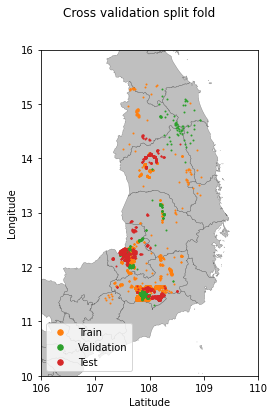

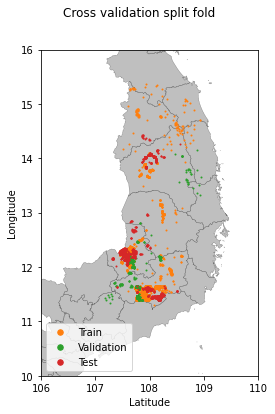

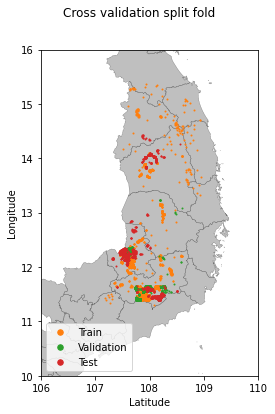

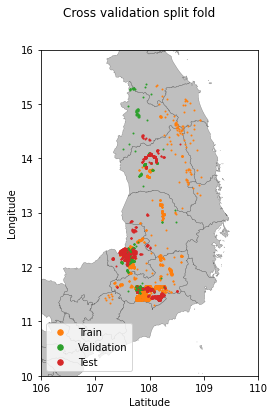

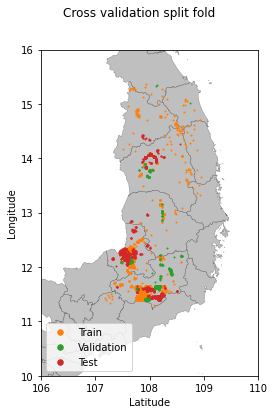

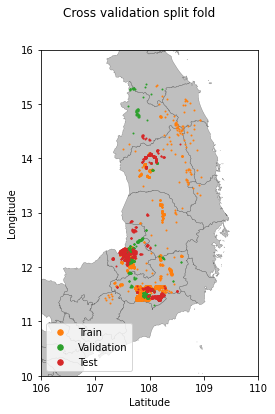

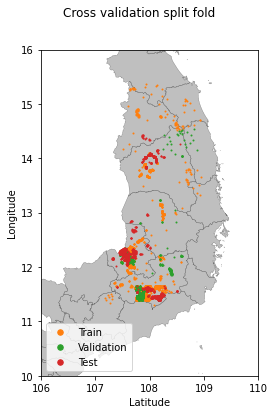

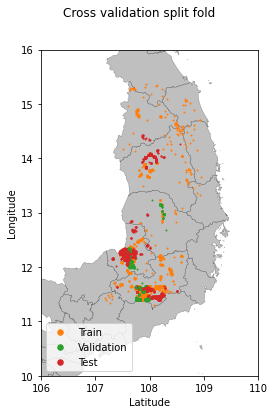

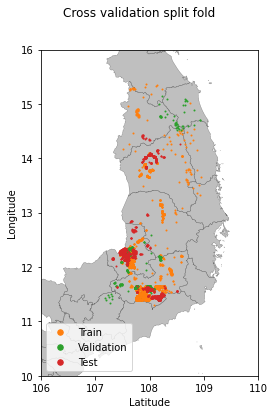

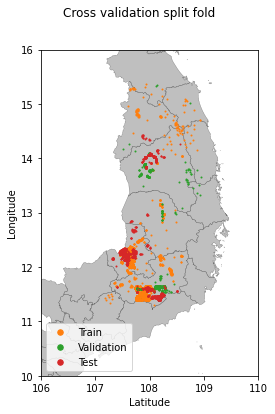

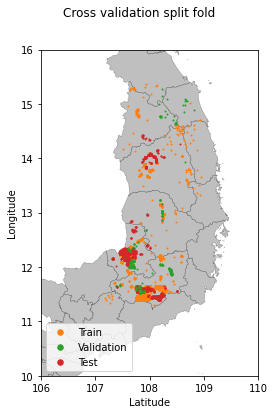

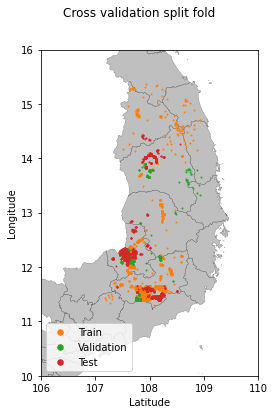

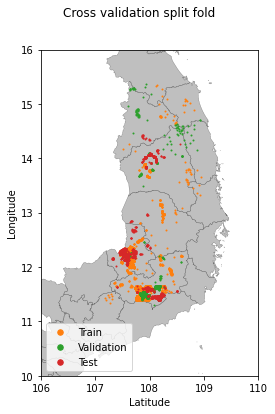

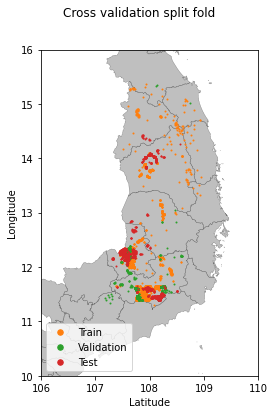

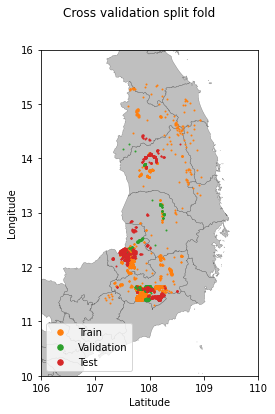

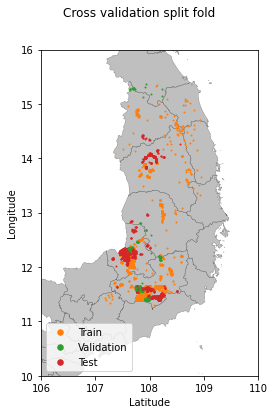

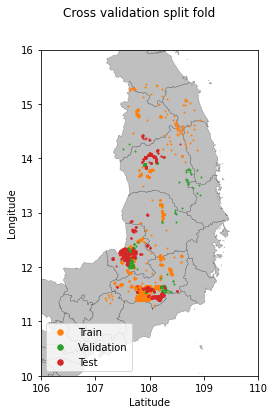

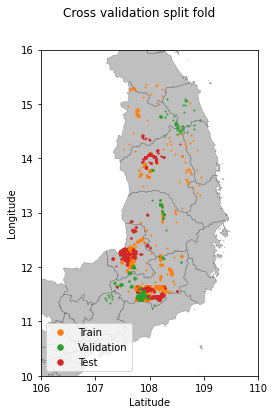

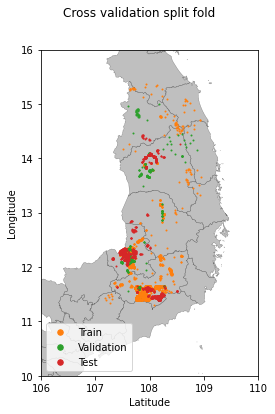

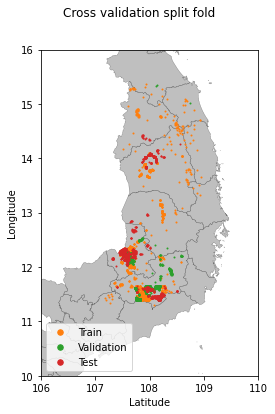

In [11]:
bands = [
    Band.COASTAL_AEROSOL.value, 
    Band.BLUE.value, 
    Band.GREEN.value, 
    Band.RED.value, 
    Band.NIR.value, 
    Band.SWIR1.value, 
    Band.SWIR2.value, 
]

# images have all the same shapes, take the shape of the first image
image_width = 9
image_height = 9
image_depth = len(bands)
nb_outputs = len(labels)

# Create model
model = Sequential([
    Rescaling(1./2**16, input_shape=(image_width, image_height, image_depth)),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    SpatialDropout2D(0.25),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(nb_outputs, activation='softmax'),
])

mean_loss, mean_accuracy, histories, conf_matrix = cross_validation_from_csv_files(model, other_csv_filename, test_csv_filename, bands, labels, EPOCHS, NB_TESTS, early_stopping=True)

In [12]:
print("mean loss: ", mean_loss)
print("mean accuracy: ", mean_accuracy)

mean loss:  3.64359460724816
mean accuracy:  1.7142579871046921


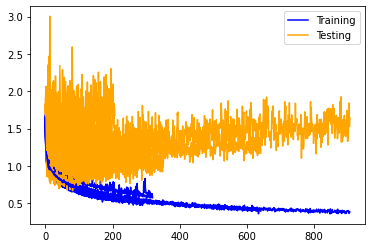

In [13]:
for i, history in enumerate(histories):
    pl.plot(history.history['loss'], label='Training', color="blue")
    pl.plot(history.history['val_loss'], label='Testing', color="orange")
    
    if i == 0:
        pl.legend()
        
    pl.grid()

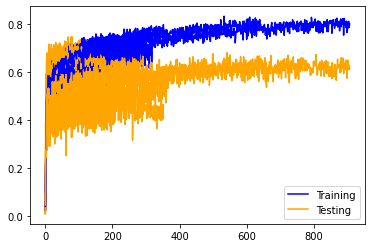

In [14]:
for i, history in enumerate(histories):
    pl.plot(history.history['f1_score_train'], label='Training', color="blue")
    pl.plot(history.history['f1_score_val'], label='Testing', color="orange")
    
    if i == 0:
        pl.legend()
        
    pl.grid()

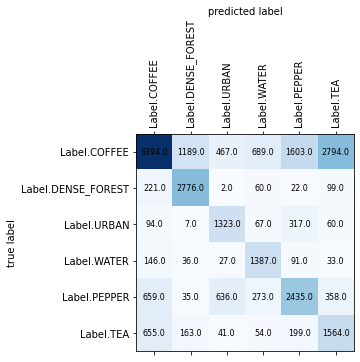

In [15]:
plot_confusion_matrix(conf_matrix, labels)

In [16]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrix)

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.78271514 0.66000951 0.53004808 0.54822134 0.52174845 0.31866341]
Mean precision:  0.5602343211424833

Recalls:  [0.48675396 0.87295597 0.70824411 0.80639535 0.55391265 0.58445441]
Mean recall:  0.6687860751740521

F-Score:  [0.60023469 0.75169239 0.60632447 0.65270588 0.53734966 0.41244726]
Mean f-score:  0.5934590589779368
